# Import Library

In [ ]:
pip install scikeras[tensorflow]


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install seaborn


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install wordcloud


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import gensim
from wordcloud import WordCloud, STOPWORDS
from gensim.models import KeyedVectors
import gensim.models.keyedvectors as word2vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from keras.models import model_from_json
import pickle
import json
import logging

logging.basicConfig(format = '%(asctime)s : %(levelname) s : %(message)s', level = logging.INFO)

print('ALL LIBRARY IMPORTED.')

from google.colab import drive
drive.mount('/content/drive')

ALL LIBRARY IMPORTED.


# Load & Preprocess Data

In [ ]:
df = pd.read_csv('drive/Sentyment Analysis using Boosting/tweets_data.csv')
print('Data loaded.\n')

Data loaded.



In [ ]:
df.drop('Unnamed: 0', axis=1, inplace = True)
df.dropna(inplace = True)

## Take random 10.000 data from each labels, total 20.000 data

In [ ]:
df_1 = df[df['label'] == 1]
df_0 = df[df['label'] == 0]

df_1 = df_1.sample(n = 10000)
df_0 = df_0.sample(n = 10000)

In [ ]:
df = pd.concat([df_1, df_0], ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
df['label'].value_counts()

1    10000
0    10000
Name: label, dtype: int64

# Build Corpus

In [ ]:
# Frequent words removal
freq = ['rt','im','ð','ðð','ððð','ðððð','ððððð','amp','u','â','retweet']
df['tweet_punc_remv'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df.drop('tweet', axis = 1, inplace = True)
df = df.rename(columns = {'tweet_punc_remv':'tweet'})

# Membuat korpus
corpus = df['tweet'].apply(gensim.utils.simple_preprocess)

# Memberi indeks pada teks
token = Tokenizer()
token.fit_on_texts(corpus)
token.index_word
token.texts_to_sequences(corpus)

#Jumlah kata dalam korpus
vocal = len(token.index_word)+1
print('There are {} words.'.format(vocal))

There are 24328 words.


# Defining X and Y & Pad sequences

In [ ]:
maxword = 30
X = token.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen = maxword, padding = 'post')
y = df['label'].values.tolist()
print('X and y defined')

X and y defined


# Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 42)
print('Training and testing data defined.')

Training and testing data defined.


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print('Done')

Done


# Word2vec

## Embedding layer

In [ ]:
pretrainedpath = 'drive/Sentyment Analysis using Boosting/w2vModel.bin'
w2vmodel = KeyedVectors.load_word2vec_format(pretrainedpath, binary = True, limit = 150000)
print('Model word2vec loaded.')

In [ ]:
embedding_layer = Embedding(input_dim = 150000, output_dim = 300, weights = [w2vmodel.vectors], 
                            input_length = X.shape[1],trainable = False)
print('Embedding layer defined.')

Embedding layer defined.


## Hyperparameter Tuning Parameter Model Word2vec




In [ ]:
def get_model_cnn(learning_rate = 0.01):

  #Define model
    model = Sequential()
    model.add(embedding_layer)
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
 
    #Compile model
    adam = Adam(learning_rate = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [ ]:
%%time
# Early Stopping
monitor = EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 10)

# Memdefinisikan Model
model_cnn = KerasClassifier(model = get_model_cnn,
                            callbacks = [monitor],epochs = 50,
                            learning_rate = 0.01, verbose = 1)

# define the grid search parameters
params_cnn = { 'batch_size': [32,64,128],
              'learning_rate': [0.01,0.001],
              'epochs': [50,100]}

ht_cnn = GridSearchCV(model_cnn,param_grid = params_cnn,
                       scoring = 'accuracy') 

hyt_cnn = ht_cnn.fit(X_train, y_train, validation_data = (X_test, y_test));
print("\nThe best parameter is {}".format(hyt_cnn.best_params_))
print("\nThe best_accuracy is {}".format(hyt_cnn.best_score_))

Epoch 1/50
375/375 [==============================] - 9s 22ms/step - loss: 0.5787 - accuracy: 0.7114 - val_loss: 0.8180 - val_accuracy: 0.5836
Epoch 2/50
375/375 [==============================] - 8s 21ms/step - loss: 0.3672 - accuracy: 0.8412 - val_loss: 0.3107 - val_accuracy: 0.8706
Epoch 3/50
375/375 [==============================] - 8s 21ms/step - loss: 0.2502 - accuracy: 0.8972 - val_loss: 0.2916 - val_accuracy: 0.8832
Epoch 4/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1725 - accuracy: 0.9326 - val_loss: 0.3113 - val_accuracy: 0.8782
Epoch 5/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1363 - accuracy: 0.9481 - val_loss: 0.3131 - val_accuracy: 0.8842
Epoch 6/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1110 - accuracy: 0.9593 - val_loss: 0.3428 - val_accuracy: 0.8802
Epoch 7/50
375/375 [==============================] - 8s 21ms/step - loss: 0.0972 - accuracy: 0.9658 - val_loss: 0.3787 - val_accuracy: 0.8712

375/375 [==============================] - 9s 21ms/step - loss: 0.5734 - accuracy: 0.7163 - val_loss: 0.8889 - val_accuracy: 0.6192
Epoch 2/50
375/375 [==============================] - 8s 20ms/step - loss: 0.3683 - accuracy: 0.8411 - val_loss: 0.3035 - val_accuracy: 0.8724
Epoch 3/50
375/375 [==============================] - 8s 20ms/step - loss: 0.2446 - accuracy: 0.9008 - val_loss: 0.2925 - val_accuracy: 0.8800
Epoch 4/50
375/375 [==============================] - 8s 20ms/step - loss: 0.1723 - accuracy: 0.9347 - val_loss: 0.3183 - val_accuracy: 0.8842
Epoch 5/50
375/375 [==============================] - 8s 20ms/step - loss: 0.1339 - accuracy: 0.9498 - val_loss: 0.3237 - val_accuracy: 0.8824
Epoch 6/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1230 - accuracy: 0.9538 - val_loss: 0.3174 - val_accuracy: 0.8820
Epoch 7/50
375/375 [==============================] - 8s 20ms/step - loss: 0.0996 - accuracy: 0.9644 - val_loss: 0.3594 - val_accuracy: 0.8790
Epoch 8/50

375/375 [==============================] - 9s 21ms/step - loss: 0.5831 - accuracy: 0.7128 - val_loss: 1.2093 - val_accuracy: 0.5154
Epoch 2/100
375/375 [==============================] - 8s 21ms/step - loss: 0.3811 - accuracy: 0.8328 - val_loss: 0.3244 - val_accuracy: 0.8614
Epoch 3/100
375/375 [==============================] - 8s 21ms/step - loss: 0.2525 - accuracy: 0.8942 - val_loss: 0.3101 - val_accuracy: 0.8692
Epoch 4/100
375/375 [==============================] - 8s 21ms/step - loss: 0.1791 - accuracy: 0.9285 - val_loss: 0.3045 - val_accuracy: 0.8808
Epoch 5/100
375/375 [==============================] - 8s 21ms/step - loss: 0.1397 - accuracy: 0.9468 - val_loss: 0.3304 - val_accuracy: 0.8692
Epoch 6/100
375/375 [==============================] - 8s 21ms/step - loss: 0.1142 - accuracy: 0.9582 - val_loss: 0.3482 - val_accuracy: 0.8716
Epoch 7/100
375/375 [==============================] - 8s 21ms/step - loss: 0.0954 - accuracy: 0.9654 - val_loss: 0.3512 - val_accuracy: 0.8812
Epoc

94/94 [==============================] - 1s 11ms/step
Epoch 1/100
375/375 [==============================] - 19s 45ms/step - loss: 0.5588 - accuracy: 0.7251 - val_loss: 1.1282 - val_accuracy: 0.5144
Epoch 2/100
375/375 [==============================] - 16s 43ms/step - loss: 0.3523 - accuracy: 0.8475 - val_loss: 0.3008 - val_accuracy: 0.8726
Epoch 3/100
375/375 [==============================] - 16s 42ms/step - loss: 0.2436 - accuracy: 0.8992 - val_loss: 0.2844 - val_accuracy: 0.8808
Epoch 4/100
375/375 [==============================] - 16s 43ms/step - loss: 0.1760 - accuracy: 0.9314 - val_loss: 0.2979 - val_accuracy: 0.8744
Epoch 5/100
375/375 [==============================] - 16s 42ms/step - loss: 0.1350 - accuracy: 0.9477 - val_loss: 0.3061 - val_accuracy: 0.8768
Epoch 6/100
375/375 [==============================] - 16s 43ms/step - loss: 0.1152 - accuracy: 0.9570 - val_loss: 0.3169 - val_accuracy: 0.8922
Epoch 7/100
375/375 [==============================] - 16s 42ms/step - loss:

94/94 [==============================] - 1s 11ms/step
Epoch 1/50
188/188 [==============================] - 18s 79ms/step - loss: 0.6028 - accuracy: 0.7002 - val_loss: 2.1570 - val_accuracy: 0.5048
Epoch 2/50
188/188 [==============================] - 15s 78ms/step - loss: 0.3829 - accuracy: 0.8301 - val_loss: 1.2314 - val_accuracy: 0.5188
Epoch 3/50
188/188 [==============================] - 14s 75ms/step - loss: 0.2602 - accuracy: 0.8953 - val_loss: 0.5535 - val_accuracy: 0.7470
Epoch 4/50
188/188 [==============================] - 15s 79ms/step - loss: 0.1694 - accuracy: 0.9337 - val_loss: 0.3623 - val_accuracy: 0.8588
Epoch 5/50
188/188 [==============================] - 14s 76ms/step - loss: 0.1234 - accuracy: 0.9523 - val_loss: 0.3473 - val_accuracy: 0.8746
Epoch 6/50
188/188 [==============================] - 14s 74ms/step - loss: 0.1012 - accuracy: 0.9622 - val_loss: 0.3648 - val_accuracy: 0.8778
Epoch 7/50
188/188 [==============================] - 13s 71ms/step - loss: 0.0785

188/188 [==============================] - 15s 80ms/step - loss: 0.0571 - accuracy: 0.9788 - val_loss: 0.4039 - val_accuracy: 0.8916
Epoch 11/50
47/47 [==============================] - 1s 19ms/step
Epoch 1/50
188/188 [==============================] - 18s 82ms/step - loss: 0.5855 - accuracy: 0.7063 - val_loss: 1.6799 - val_accuracy: 0.5048
Epoch 2/50
188/188 [==============================] - 15s 78ms/step - loss: 0.3867 - accuracy: 0.8288 - val_loss: 1.8434 - val_accuracy: 0.5140
Epoch 3/50
188/188 [==============================] - 15s 78ms/step - loss: 0.2657 - accuracy: 0.8938 - val_loss: 0.5449 - val_accuracy: 0.7518
Epoch 4/50
188/188 [==============================] - 14s 74ms/step - loss: 0.1754 - accuracy: 0.9287 - val_loss: 0.3305 - val_accuracy: 0.8722
Epoch 5/50
188/188 [==============================] - 15s 81ms/step - loss: 0.1183 - accuracy: 0.9566 - val_loss: 0.4041 - val_accuracy: 0.8568
Epoch 6/50
188/188 [==============================] - 15s 82ms/step - loss: 0.088

188/188 [==============================] - 15s 80ms/step - loss: 0.0598 - accuracy: 0.9780 - val_loss: 0.4386 - val_accuracy: 0.8594
Epoch 10/50
188/188 [==============================] - 15s 79ms/step - loss: 0.0613 - accuracy: 0.9778 - val_loss: 0.3753 - val_accuracy: 0.8842
Epoch 11/50
47/47 [==============================] - 1s 18ms/step
Epoch 1/100
188/188 [==============================] - 18s 81ms/step - loss: 0.6077 - accuracy: 0.6978 - val_loss: 1.5039 - val_accuracy: 0.5048
Epoch 2/100
188/188 [==============================] - 15s 80ms/step - loss: 0.3962 - accuracy: 0.8281 - val_loss: 1.0401 - val_accuracy: 0.5306
Epoch 3/100
188/188 [==============================] - 15s 80ms/step - loss: 0.2748 - accuracy: 0.8893 - val_loss: 0.3055 - val_accuracy: 0.8670
Epoch 4/100
188/188 [==============================] - 15s 77ms/step - loss: 0.1870 - accuracy: 0.9270 - val_loss: 0.3120 - val_accuracy: 0.8692
Epoch 5/100
188/188 [==============================] - 15s 80ms/step - loss:

188/188 [==============================] - 15s 81ms/step - loss: 0.0778 - accuracy: 0.9701 - val_loss: 0.4209 - val_accuracy: 0.8552
Epoch 9/100
188/188 [==============================] - 15s 79ms/step - loss: 0.0648 - accuracy: 0.9763 - val_loss: 0.4172 - val_accuracy: 0.8688
Epoch 10/100
188/188 [==============================] - 15s 79ms/step - loss: 0.0566 - accuracy: 0.9801 - val_loss: 0.3754 - val_accuracy: 0.8856
Epoch 11/100
47/47 [==============================] - 1s 19ms/step
Epoch 1/100
188/188 [==============================] - 18s 82ms/step - loss: 0.5881 - accuracy: 0.7078 - val_loss: 1.4125 - val_accuracy: 0.5048
Epoch 2/100
188/188 [==============================] - 15s 79ms/step - loss: 0.3866 - accuracy: 0.8310 - val_loss: 0.7113 - val_accuracy: 0.5666
Epoch 3/100
188/188 [==============================] - 15s 78ms/step - loss: 0.2557 - accuracy: 0.8933 - val_loss: 0.4137 - val_accuracy: 0.8062
Epoch 4/100
188/188 [==============================] - 15s 80ms/step - los

188/188 [==============================] - 15s 79ms/step - loss: 0.0795 - accuracy: 0.9714 - val_loss: 0.3600 - val_accuracy: 0.8834
Epoch 8/100
188/188 [==============================] - 15s 79ms/step - loss: 0.0772 - accuracy: 0.9712 - val_loss: 0.4011 - val_accuracy: 0.8742
Epoch 9/100
188/188 [==============================] - 14s 75ms/step - loss: 0.0647 - accuracy: 0.9766 - val_loss: 0.4499 - val_accuracy: 0.8686
Epoch 10/100
188/188 [==============================] - 15s 80ms/step - loss: 0.0597 - accuracy: 0.9789 - val_loss: 0.4398 - val_accuracy: 0.8732
Epoch 11/100
47/47 [==============================] - 1s 19ms/step
Epoch 1/50
94/94 [==============================] - 15s 135ms/step - loss: 0.5941 - accuracy: 0.7038 - val_loss: 1.0864 - val_accuracy: 0.5048
Epoch 2/50
94/94 [==============================] - 12s 129ms/step - loss: 0.4050 - accuracy: 0.8160 - val_loss: 1.4702 - val_accuracy: 0.5048
Epoch 3/50
94/94 [==============================] - 12s 129ms/step - loss: 0.2

94/94 [==============================] - 13s 135ms/step - loss: 0.2891 - accuracy: 0.8779 - val_loss: 0.8537 - val_accuracy: 0.5300
Epoch 4/50
94/94 [==============================] - 13s 136ms/step - loss: 0.1873 - accuracy: 0.9247 - val_loss: 0.4876 - val_accuracy: 0.7712
Epoch 5/50
94/94 [==============================] - 13s 138ms/step - loss: 0.1317 - accuracy: 0.9506 - val_loss: 0.5601 - val_accuracy: 0.7568
Epoch 6/50
94/94 [==============================] - 13s 138ms/step - loss: 0.0885 - accuracy: 0.9688 - val_loss: 0.4592 - val_accuracy: 0.8452
Epoch 7/50
94/94 [==============================] - 13s 137ms/step - loss: 0.0700 - accuracy: 0.9753 - val_loss: 0.3867 - val_accuracy: 0.8690
Epoch 8/50
94/94 [==============================] - 12s 133ms/step - loss: 0.0673 - accuracy: 0.9748 - val_loss: 0.3975 - val_accuracy: 0.8802
Epoch 9/50
94/94 [==============================] - 13s 135ms/step - loss: 0.0529 - accuracy: 0.9808 - val_loss: 0.4219 - val_accuracy: 0.8852
Epoch 10/5

Epoch 10/50
94/94 [==============================] - 13s 137ms/step - loss: 0.0521 - accuracy: 0.9819 - val_loss: 0.4713 - val_accuracy: 0.8666
Epoch 11/50
94/94 [==============================] - 13s 136ms/step - loss: 0.0476 - accuracy: 0.9822 - val_loss: 0.4106 - val_accuracy: 0.8872
Epoch 12/50
94/94 [==============================] - 13s 136ms/step - loss: 0.0439 - accuracy: 0.9845 - val_loss: 0.4663 - val_accuracy: 0.8682
Epoch 13/50
24/24 [==============================] - 1s 29ms/step
Epoch 1/50
94/94 [==============================] - 16s 144ms/step - loss: 0.6522 - accuracy: 0.6729 - val_loss: 1.2620 - val_accuracy: 0.5048
Epoch 2/50
94/94 [==============================] - 12s 132ms/step - loss: 0.4383 - accuracy: 0.8024 - val_loss: 2.5356 - val_accuracy: 0.5048
Epoch 3/50
94/94 [==============================] - 12s 129ms/step - loss: 0.3262 - accuracy: 0.8622 - val_loss: 1.7056 - val_accuracy: 0.5048
Epoch 4/50
94/94 [==============================] - 13s 134ms/step - loss

94/94 [==============================] - 7s 71ms/step - loss: 0.1989 - accuracy: 0.9203 - val_loss: 0.8024 - val_accuracy: 0.6198
Epoch 5/100
94/94 [==============================] - 7s 72ms/step - loss: 0.1313 - accuracy: 0.9503 - val_loss: 0.6285 - val_accuracy: 0.7584
Epoch 6/100
94/94 [==============================] - 7s 72ms/step - loss: 0.0994 - accuracy: 0.9624 - val_loss: 0.4108 - val_accuracy: 0.8586
Epoch 7/100
94/94 [==============================] - 7s 73ms/step - loss: 0.0725 - accuracy: 0.9718 - val_loss: 0.3933 - val_accuracy: 0.8790
Epoch 8/100
94/94 [==============================] - 7s 73ms/step - loss: 0.0628 - accuracy: 0.9776 - val_loss: 0.4934 - val_accuracy: 0.8554
Epoch 9/100
94/94 [==============================] - 7s 74ms/step - loss: 0.0555 - accuracy: 0.9803 - val_loss: 0.4458 - val_accuracy: 0.8754
Epoch 10/100
94/94 [==============================] - 7s 77ms/step - loss: 0.0539 - accuracy: 0.9818 - val_loss: 0.4503 - val_accuracy: 0.8764
Epoch 11/100
94/9

94/94 [==============================] - 10s 107ms/step - loss: 0.0582 - accuracy: 0.9791 - val_loss: 0.4435 - val_accuracy: 0.8796
Epoch 10/100
94/94 [==============================] - 10s 101ms/step - loss: 0.0543 - accuracy: 0.9812 - val_loss: 0.4514 - val_accuracy: 0.8724
Epoch 11/100
94/94 [==============================] - 10s 103ms/step - loss: 0.0433 - accuracy: 0.9840 - val_loss: 0.4496 - val_accuracy: 0.8764
Epoch 12/100
24/24 [==============================] - 1s 17ms/step
Epoch 1/100
94/94 [==============================] - 12s 111ms/step - loss: 0.6240 - accuracy: 0.6845 - val_loss: 0.9088 - val_accuracy: 0.5048
Epoch 2/100
94/94 [==============================] - 9s 99ms/step - loss: 0.4243 - accuracy: 0.8121 - val_loss: 1.1872 - val_accuracy: 0.5048
Epoch 3/100
94/94 [==============================] - 9s 94ms/step - loss: 0.2995 - accuracy: 0.8722 - val_loss: 0.9740 - val_accuracy: 0.5048
Epoch 4/100
94/94 [==============================] - 7s 71ms/step - loss: 0.2002 - 

  ### Fit Model Word2Vec

In [ ]:
%%time
# Early Stopping
monitor = EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 10 )

model = Sequential()
model.add(embedding_layer)
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 3))
model.add(BatchNormalization())
model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 3))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
 
#Compile model
adam = Adam(learning_rate = 0.01)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization_366 (Ba  (None, 30, 300)          1200      
 tchNormalization)                                               
                                                                 
 dropout_305 (Dropout)       (None, 30, 300)           0         
                                                                 
 conv1d_122 (Conv1D)         (None, 30, 256)           384256    
                                                                 
 max_pooling1d_122 (MaxPooli  (None, 10, 256)          0         
 ng1D)                                                           
                                                                 
 batch_normalization_367 (Ba  (None, 10, 256)        

In [ ]:
%%time
#Fitting model
w2vec_model = model.fit(X_train, y_train, epochs = 100, batch_size = 64, callbacks = [monitor],
                          validation_data = (X_test, y_test))

Epoch 1/100
235/235 [==============================] - 11s 43ms/step - loss: 0.5460 - accuracy: 0.7317 - val_loss: 1.1168 - val_accuracy: 0.5054
Epoch 2/100
235/235 [==============================] - 10s 42ms/step - loss: 0.3502 - accuracy: 0.8487 - val_loss: 0.5053 - val_accuracy: 0.7486
Epoch 3/100
235/235 [==============================] - 10s 43ms/step - loss: 0.2308 - accuracy: 0.9073 - val_loss: 0.3321 - val_accuracy: 0.8574
Epoch 4/100
235/235 [==============================] - 10s 42ms/step - loss: 0.1619 - accuracy: 0.9361 - val_loss: 0.2965 - val_accuracy: 0.8842
Epoch 5/100
235/235 [==============================] - 10s 42ms/step - loss: 0.1222 - accuracy: 0.9531 - val_loss: 0.3353 - val_accuracy: 0.8784
Epoch 6/100
235/235 [==============================] - 10s 41ms/step - loss: 0.0925 - accuracy: 0.9653 - val_loss: 0.3930 - val_accuracy: 0.8692
Epoch 7/100
235/235 [==============================] - 10s 42ms/step - loss: 0.0854 - accuracy: 0.9686 - val_loss: 0.3403 - val_ac

### Evaluate Model Word2Vec

In [ ]:
loss_w2vec, acc_w2vec = model.evaluate(X_test, y_test, batch_size = 64)
print('Model loss: {}'.format(loss_w2vec))
print('Model acc: {}'.format(acc_w2vec))

79/79 [==============================] - 1s 10ms/step - loss: 0.3587 - accuracy: 0.8928
Model loss: 0.35873305797576904
Model acc: 0.892799973487854


### Visualization Model Word2vec


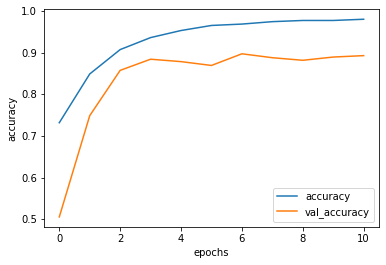

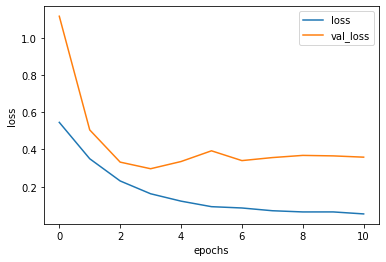

In [ ]:
def plot_graphs(w2vec_model,string):
    plt.plot(w2vec_model.history[string])
    plt.plot(w2vec_model.history['val_'+string])
    plt.xlabel("epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(w2vec_model, "accuracy")
plot_graphs(w2vec_model, "loss") 

### Predict Model 

In [ ]:
#Predict model
y_pred = model.predict(X_test)
print('Prediction done.')

157/157 [==============================] - 1s 6ms/step
Prediction done.


In [ ]:
y_pred

array([[0.0142678 ],
       [0.9963596 ],
       [0.24873239],
       ...,
       [0.9966225 ],
       [0.5842497 ],
       [0.2184445 ]], dtype=float32)

In [ ]:
labels = [0,1]

In [ ]:
prediction_labels=[]
for p in y_pred:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
sum(y_test==prediction_labels)/len(prediction_labels)

0.4952

In [ ]:
y_pred = prediction_labels

### Confusion Matrix

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2476    0]
 [2524    0]]


In [ ]:
print(classification_report(y_test, y_pred,zero_division = 1))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2476
           1       1.00      0.00      0.00      2524

    accuracy                           0.50      5000
   macro avg       0.75      0.50      0.33      5000
weighted avg       0.75      0.50      0.33      5000



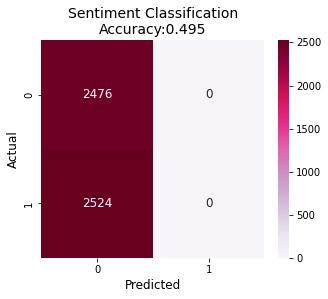

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.66      2476
           1       0.00      0.00      0.00      2524

    accuracy                           0.50      5000
   macro avg       0.25      0.50      0.33      5000
weighted avg       0.25      0.50      0.33      5000



C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Visualize confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt=".0f", cmap="PuRd", annot_kws={"fontsize":12})
plt.title("Sentiment Classification\nAccuracy:{:.3f}".format(accuracy_score(y_test, y_pred)), fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))

# Boosting

In [ ]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(n_estimators = 1000, learning_rate = 0.01).fit(X_train, y_train, early_stopping_rounds = 10, eval_set = [(X_test, y_test)],verbose = False)
score_xgb = xgboost.score(X_test,y_test)
score_xgb

C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.9024

In [ ]:
#Predict the response for test dataset
y_boost_pred = xgboost.predict(X_test)

In [ ]:
# Print classification report
print(classification_report(y_test, y_boost_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2476
           1       0.91      0.89      0.90      2524

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [ ]:
# Confusion matrix boosting
cmb = confusion_matrix(y_test,y_boost_pred)
cmb

array([[2254,  222],
       [ 266, 2258]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix Word2Vec for Sentiment Classification after Boosting')

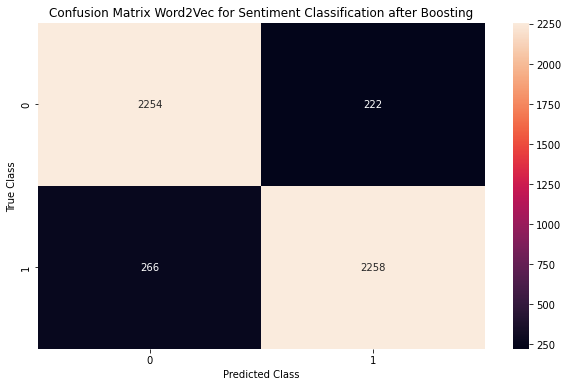

In [ ]:
#Visualize confusion matrix

fig = plt.figure(figsize = (10, 6))
sns.heatmap(cmb, annot = True, fmt = "d")

# Labeling the X-axis
plt.xlabel("Predicted Class")

# Labeling the Y-axis
plt.ylabel("True Class")

# Give a title to the graph
plt.title("Confusion Matrix Word2Vec for Sentiment Classification after Boosting")